In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import random
import torch
import numpy as np
import seaborn as sns

from data_analysis_preparation.utils import filter_df_by_problem
from dataloader import Mri3DDataLoader
from model import MRINet
from training_loop import evaluate_model, run_training_loop

### Reproducibility

In [2]:
torch.manual_seed(2**30) 
random.seed(2**30)
np.random.seed(2**30)

### Load data

In [3]:
TRAIN_DATA_PATH = "/home/dpolak/alzheimer_disease_classification_tools/tabular_data/train_base.csv"
TEST_DATA_PATH = "/home/dpolak/alzheimer_disease_classification_tools/tabular_data/test_base.csv"
VALID_DATA_PATH = "/home/dpolak/alzheimer_disease_classification_tools/tabular_data/val_base.csv"
BIOCARD_DATA_PATH = "/home/dpolak/alzheimer_disease_classification_tools/tabular_data/biocard_test_set.csv"
MODEL_SAVE_DIRECTORY = "/home/dpolak/alzheimer_disease_classification_tools/models"

In [4]:
train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
valid_df = pd.read_csv(VALID_DATA_PATH)
biocard_df = pd.read_csv(BIOCARD_DATA_PATH)
num_epochs = 10

### Training and evaluation process

In [5]:
def plot_confusion_matrix(results: dict, problem: str, dataset: str) -> None:
    columns = problems[problem]
    cf_matrix = results[problem][dataset]["confusion_matrix"]
    s = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
                    fmt='.2%', cmap='Blues', xticklabels=columns,
                    yticklabels=columns)
    s.set_xlabel("Predicted label")
    s.set_ylabel("True label")

In [6]:
problems = {"AD vs CN": ["AD", "CN"] , "AD vs MCI": ["AD", "MCI"], "MCI vs CN": ["MCI", "CN"], "AD vs MCI vs CN": ["MCI", "CN", "AD"], "p-MCI vs np-MCI": ["p-MCI", "np-MCI"]}
batch_size = 4


In [7]:
histories = {}
results = {problem: {} for problem in problems}
for problem, columns in problems.items():
    print(f"Training {problem}")
    _train_df = Mri3DDataLoader(filter_df_by_problem(problem, train_df), classification_values=columns,
                                batch_size=batch_size, crop=False)
    _test_df = Mri3DDataLoader(filter_df_by_problem(problem, test_df), classification_values=columns,
                               batch_size=batch_size, crop=False)
    _valid_df = Mri3DDataLoader(filter_df_by_problem(problem, valid_df), classification_values=columns,
                                batch_size=batch_size, crop=False)
    if problem != "p-MCI vs np-MCI":
        _biocard_df = Mri3DDataLoader(filter_df_by_problem(problem, biocard_df),
                                      classification_values=columns, batch_size=batch_size, crop=True)
    else:
        _biocard_df = None
    save_directory = Path(MODEL_SAVE_DIRECTORY, problem)
    model = MRINet(num_classes=2 if problem != "AD vs MCI vs CN" else 3)
    state_dict = torch.load(r"/home/dpolak/alzheimer_disease_classification_tools/imaging_models/models/pretrained/best_model.pth")
    state_dict.pop('classifier.2.weight')
    state_dict.pop('classifier.2.bias')
    model.load_state_dict(state_dict, strict=False)
    model.to("cuda")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    history = run_training_loop(model = model,
                                train_dataset=_train_df,
                                valid_dataset=_valid_df,
                                num_epochs = num_epochs,
                                optimizer = optimizer,
                                batch_size = batch_size,
                                save_directory = save_directory,
                                from_pretrained = True,
                                scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, last_epoch=-1))
    histories[problem] = history
    model.load_state_dict(torch.load(Path(save_directory, "best_model.pth")))
    results[problem] = {
        "train": evaluate_model(model, _train_df),
        "test": evaluate_model(model, _test_df),
        "valid": evaluate_model(model, _valid_df),
        "biocard": evaluate_model(model, _biocard_df) if _biocard_df is not None else None
    }
    print(results)

Training AD vs CN
Freezing all layers except the last fully connected layer.


Epoch: 0, LR: [0.001] Step loss: 0.571, Step acc: 2, Train Accuracy: 0.529, Balanced Accuracy: 0.529, Running Loss: 1.109: 100%|█| 41
Validation Loss - item: 0.81, Validation Accuracy: 0.583, Balanced accuracy: 0.567, Running Loss: 0.712: 100%|█| 51/51 [00:28<00:00, 



Best validation accuracy: 0.5666730898930533

Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 0.889, Step acc: 2, Train Accuracy: 0.642, Balanced Accuracy: 0.642, Running Loss: 0.747: 100%|█| 41
Validation Loss - item: 0.237, Validation Accuracy: 0.73, Balanced accuracy: 0.716, Running Loss: 0.595: 100%|█| 51/51 [00:29<00:00, 



Best validation accuracy: 0.7164948453608248

Saving best model for epoch: 2



Epoch: 2, LR: [0.001] Step loss: 0.853, Step acc: 3, Train Accuracy: 0.749, Balanced Accuracy: 0.749, Running Loss: 0.531: 100%|█| 41
Validation Loss - item: 1.019, Validation Accuracy: 0.765, Balanced accuracy: 0.753, Running Loss: 0.538: 100%|█| 51/51 [00:29<00:00,



Best validation accuracy: 0.7525773195876289

Saving best model for epoch: 3



  0%|                                                                                                        | 0/412 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 3, LR: [0.0001] Step loss: 0.435, Step acc: 3, Train Accuracy: 0.837, Balanced Accuracy: 0.836, Running Loss: 0.397: 100%|█| 4
Validation Loss - item: 0.168, Validation Accuracy: 0.863, Balanced accuracy: 0.858, Running Loss: 0.343: 100%|█| 51/51 [00:29<00:00,



Best validation accuracy: 0.8580788129877637

Saving best model for epoch: 4



Epoch: 4, LR: [0.0001] Step loss: 0.241, Step acc: 4, Train Accuracy: 0.856, Balanced Accuracy: 0.855, Running Loss: 0.348: 100%|█| 4
Validation Loss - item: 0.049, Validation Accuracy: 0.853, Balanced accuracy: 0.853, Running Loss: 0.344: 100%|█| 51/51 [00:29<00:00,
Epoch: 5, LR: [0.0001] Step loss: 0.401, Step acc: 3, Train Accuracy: 0.865, Balanced Accuracy: 0.864, Running Loss: 0.323: 100%|█| 4
Validation Loss - item: 0.356, Validation Accuracy: 0.833, Balanced accuracy: 0.834, Running Loss: 0.372: 100%|█| 51/51 [00:29<00:00,
Epoch: 6, LR: [1e-05] Step loss: 0.099, Step acc: 4, Train Accuracy: 0.89, Balanced Accuracy: 0.89, Running Loss: 0.291: 100%|█| 412/
Validation Loss - item: 0.087, Validation Accuracy: 0.853, Balanced accuracy: 0.852, Running Loss: 0.34: 100%|█| 51/51 [00:29<00:00, 
Epoch: 7, LR: [1e-05] Step loss: 0.251, Step acc: 3, Train Accuracy: 0.89, Balanced Accuracy: 0.89, Running Loss: 0.285: 100%|█| 412/
Validation Loss - item: 0.065, Validation Accuracy: 0.858, Bal


Best validation accuracy: 0.8614510068407362

Saving best model for epoch: 9



Epoch: 9, LR: [1.0000000000000002e-06] Step loss: 0.569, Step acc: 3, Train Accuracy: 0.889, Balanced Accuracy: 0.889, Running Loss: 
Validation Loss - item: 0.184, Validation Accuracy: 0.848, Balanced accuracy: 0.847, Running Loss: 0.333: 100%|█| 51/51 [00:29<00:00,
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [01:12<00:00,  1.18it/s]


{'AD vs CN': {'train': {'accuracy': 0.9053398058252428, 'balanced_accuracy': 0.9048277649879883, 'roc_auc': 0.9048277649879883, 'roc_curve': (array([0.        , 0.15544676, 1.        ]), array([0.        , 0.96510229, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[690, 127],
       [ 29, 802]])}, 'test': {'accuracy': 0.8066037735849056, 'balanced_accuracy': 0.8019707565162111, 'roc_auc': 0.8019707565162111, 'roc_curve': (array([0.        , 0.23076923, 1.        ]), array([0.        , 0.83471074, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 70,  21],
       [ 20, 101]])}, 'valid': {'accuracy': 0.8627450980392157, 'balanced_accuracy': 0.8614510068407362, 'roc_auc': 0.8614510068407362, 'roc_curve': (array([0.        , 0.16494845, 1.        ]), array([0.        , 0.88785047, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[81, 16],
       [12, 95]])}, 'biocard': {'accuracy': 0.09705882352941177, 'balanced_accuracy': 0.54041916167

Epoch: 0, LR: [0.001] Step loss: 0.988, Step acc: 1, Train Accuracy: 0.541, Balanced Accuracy: 0.522, Running Loss: 1.122: 100%|█| 50
Validation Loss - item: 0.555, Validation Accuracy: 0.672, Balanced accuracy: 0.628, Running Loss: 0.631: 100%|█| 61/61 [00:35<00:00,



Best validation accuracy: 0.6279542744933024

Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 1.163, Step acc: 1, Train Accuracy: 0.586, Balanced Accuracy: 0.559, Running Loss: 0.761: 100%|█| 50
Validation Loss - item: 0.644, Validation Accuracy: 0.701, Balanced accuracy: 0.673, Running Loss: 0.599: 100%|█| 61/61 [00:35<00:00,



Best validation accuracy: 0.6728031418753069

Saving best model for epoch: 2



Epoch: 2, LR: [0.001] Step loss: 0.421, Step acc: 3, Train Accuracy: 0.666, Balanced Accuracy: 0.635, Running Loss: 0.631: 100%|█| 50
Validation Loss - item: 0.835, Validation Accuracy: 0.668, Balanced accuracy: 0.586, Running Loss: 0.644: 100%|█| 61/61 [00:35<00:00,
  0%|                                                                                                        | 0/501 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 3, LR: [0.0001] Step loss: 0.28, Step acc: 4, Train Accuracy: 0.686, Balanced Accuracy: 0.659, Running Loss: 0.593: 100%|█| 50
Validation Loss - item: 0.344, Validation Accuracy: 0.693, Balanced accuracy: 0.68, Running Loss: 0.58: 100%|█| 61/61 [00:35<00:00,  



Best validation accuracy: 0.6800266498351919

Saving best model for epoch: 4



Epoch: 4, LR: [0.0001] Step loss: 0.737, Step acc: 3, Train Accuracy: 0.718, Balanced Accuracy: 0.694, Running Loss: 0.566: 100%|█| 5
Validation Loss - item: 0.267, Validation Accuracy: 0.701, Balanced accuracy: 0.69, Running Loss: 0.565: 100%|█| 61/61 [00:34<00:00, 



Best validation accuracy: 0.6903359281857073

Saving best model for epoch: 5



Epoch: 5, LR: [0.0001] Step loss: 0.709, Step acc: 2, Train Accuracy: 0.724, Balanced Accuracy: 0.703, Running Loss: 0.553: 100%|█| 5
  0%|                                                                                                         | 0/61 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation Loss - item: 0.775, Validation Accuracy: 0.721, Balanced accuracy: 0.72, Running Loss: 0.586: 100%|█| 61/61 [00:34<00:00, 



Best validation accuracy: 0.719615681324076

Saving best model for epoch: 6



Epoch: 6, LR: [1e-05] Step loss: 0.34, Step acc: 4, Train Accuracy: 0.75, Balanced Accuracy: 0.732, Running Loss: 0.527: 100%|█| 501/
Validation Loss - item: 0.561, Validation Accuracy: 0.709, Balanced accuracy: 0.704, Running Loss: 0.579: 100%|█| 61/61 [00:34<00:00,
Epoch: 7, LR: [1e-05] Step loss: 0.778, Step acc: 2, Train Accuracy: 0.741, Balanced Accuracy: 0.72, Running Loss: 0.526: 100%|█| 501
Validation Loss - item: 0.444, Validation Accuracy: 0.705, Balanced accuracy: 0.687, Running Loss: 0.57: 100%|█| 61/61 [00:34<00:00, 
Epoch: 8, LR: [1e-05] Step loss: 0.283, Step acc: 4, Train Accuracy: 0.749, Balanced Accuracy: 0.733, Running Loss: 0.516: 100%|█| 50
Validation Loss - item: 0.354, Validation Accuracy: 0.693, Balanced accuracy: 0.673, Running Loss: 0.571: 100%|█| 61/61 [00:34<00:00,
Epoch: 9, LR: [1.0000000000000002e-06] Step loss: 0.719, Step acc: 2, Train Accuracy: 0.752, Balanced Accuracy: 0.728, Running Loss: 
Validation Loss - item: 0.404, Validation Accuracy: 0.693, Bal

{'AD vs CN': {'train': {'accuracy': 0.9053398058252428, 'balanced_accuracy': 0.9048277649879883, 'roc_auc': 0.9048277649879883, 'roc_curve': (array([0.        , 0.15544676, 1.        ]), array([0.        , 0.96510229, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[690, 127],
       [ 29, 802]])}, 'test': {'accuracy': 0.8066037735849056, 'balanced_accuracy': 0.8019707565162111, 'roc_auc': 0.8019707565162111, 'roc_curve': (array([0.        , 0.23076923, 1.        ]), array([0.        , 0.83471074, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 70,  21],
       [ 20, 101]])}, 'valid': {'accuracy': 0.8627450980392157, 'balanced_accuracy': 0.8614510068407362, 'roc_auc': 0.8614510068407362, 'roc_curve': (array([0.        , 0.16494845, 1.        ]), array([0.        , 0.88785047, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[81, 16],
       [12, 95]])}, 'biocard': {'accuracy': 0.09705882352941177, 'balanced_accuracy': 0.54041916167

  0%|                                                                                                        | 0/504 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 0, LR: [0.001] Step loss: 0.408, Step acc: 4, Train Accuracy: 0.532, Balanced Accuracy: 0.513, Running Loss: 1.102: 100%|█| 50
  0%|                                                                                                         | 0/63 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation Loss - item: 0.871, Validation Accuracy: 0.5, Balanced accuracy: 0.569, Running Loss: 0.716: 100%|█| 63/63 [00:37<00:00,  



Best validation accuracy: 0.5687074829931973

Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 0.905, Step acc: 0, Train Accuracy: 0.555, Balanced Accuracy: 0.53, Running Loss: 0.75: 100%|█| 504/
Validation Loss - item: 0.698, Validation Accuracy: 0.544, Balanced accuracy: 0.535, Running Loss: 0.675: 100%|█| 63/63 [00:36<00:00,
  0%|                                                                                                        | 0/504 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 2, LR: [0.001] Step loss: 0.636, Step acc: 2, Train Accuracy: 0.605, Balanced Accuracy: 0.572, Running Loss: 0.666: 100%|█| 50
Validation Loss - item: 0.603, Validation Accuracy: 0.587, Balanced accuracy: 0.588, Running Loss: 0.651: 100%|█| 63/63 [00:36<00:00,



Best validation accuracy: 0.5877551020408163

Saving best model for epoch: 3



Epoch: 3, LR: [0.0001] Step loss: 0.656, Step acc: 3, Train Accuracy: 0.657, Balanced Accuracy: 0.639, Running Loss: 0.608: 100%|█| 5
  0%|                                                                                                         | 0/63 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation Loss - item: 0.421, Validation Accuracy: 0.639, Balanced accuracy: 0.643, Running Loss: 0.643: 100%|█| 63/63 [00:36<00:00,



Best validation accuracy: 0.6428571428571428

Saving best model for epoch: 4



Epoch: 4, LR: [0.0001] Step loss: 0.579, Step acc: 2, Train Accuracy: 0.695, Balanced Accuracy: 0.683, Running Loss: 0.574: 100%|█| 5
Validation Loss - item: 0.276, Validation Accuracy: 0.647, Balanced accuracy: 0.623, Running Loss: 0.635: 100%|█| 63/63 [00:36<00:00,
Epoch: 5, LR: [0.0001] Step loss: 0.267, Step acc: 4, Train Accuracy: 0.727, Balanced Accuracy: 0.716, Running Loss: 0.547: 100%|█| 5
Validation Loss - item: 0.703, Validation Accuracy: 0.643, Balanced accuracy: 0.612, Running Loss: 0.621: 100%|█| 63/63 [00:36<00:00,
Epoch: 6, LR: [1e-05] Step loss: 0.607, Step acc: 2, Train Accuracy: 0.764, Balanced Accuracy: 0.757, Running Loss: 0.497: 100%|█| 50
Validation Loss - item: 0.94, Validation Accuracy: 0.635, Balanced accuracy: 0.623, Running Loss: 0.625: 100%|█| 63/63 [00:36<00:00, 
Epoch: 7, LR: [1e-05] Step loss: 0.479, Step acc: 3, Train Accuracy: 0.783, Balanced Accuracy: 0.777, Running Loss: 0.481: 100%|█| 50
Validation Loss - item: 0.514, Validation Accuracy: 0.639, Bal

{'AD vs CN': {'train': {'accuracy': 0.9053398058252428, 'balanced_accuracy': 0.9048277649879883, 'roc_auc': 0.9048277649879883, 'roc_curve': (array([0.        , 0.15544676, 1.        ]), array([0.        , 0.96510229, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[690, 127],
       [ 29, 802]])}, 'test': {'accuracy': 0.8066037735849056, 'balanced_accuracy': 0.8019707565162111, 'roc_auc': 0.8019707565162111, 'roc_curve': (array([0.        , 0.23076923, 1.        ]), array([0.        , 0.83471074, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 70,  21],
       [ 20, 101]])}, 'valid': {'accuracy': 0.8627450980392157, 'balanced_accuracy': 0.8614510068407362, 'roc_auc': 0.8614510068407362, 'roc_curve': (array([0.        , 0.16494845, 1.        ]), array([0.        , 0.88785047, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[81, 16],
       [12, 95]])}, 'biocard': {'accuracy': 0.09705882352941177, 'balanced_accuracy': 0.54041916167

Epoch: 0, LR: [0.001] Step loss: 1.244, Step acc: 2, Train Accuracy: 0.357, Balanced Accuracy: 0.347, Running Loss: 1.795: 100%|█| 70
Validation Loss - item: 0.61, Validation Accuracy: 0.42, Balanced accuracy: 0.333, Running Loss: 1.234: 100%|█| 87/87 [00:51<00:00,  



Best validation accuracy: 0.3333333333333333

Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 1.235, Step acc: 2, Train Accuracy: 0.44, Balanced Accuracy: 0.429, Running Loss: 1.11: 100%|█| 709/
  0%|                                                                                                         | 0/87 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation Loss - item: 1.093, Validation Accuracy: 0.25, Balanced accuracy: 0.5, Running Loss: 1.093:   1%| | 1/87 [00:00<00:49,  1./home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation Loss - item: 0.67, Validation Accuracy: 0.543, Balanced accuracy: 0.524, Running Loss: 0.935: 100%|█| 87/87 [00:50<00:00, 



Best validation accuracy: 0.5239932440194136

Saving best model for epoch: 2



Epoch: 2, LR: [0.001] Step loss: 1.258, Step acc: 0, Train Accuracy: 0.487, Balanced Accuracy: 0.484, Running Loss: 0.973: 100%|█| 70
  0%|                                                                                                         | 0/87 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation Loss - item: 0.819, Validation Accuracy: 0.532, Balanced accuracy: 0.522, Running Loss: 0.902: 100%|█| 87/87 [00:50<00:00,
  0%|                                                                                                        | 0/709 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 3, LR: [0.0001] Step loss: 0.674, S


Best validation accuracy: 0.5472164785617873

Saving best model for epoch: 5



Epoch: 5, LR: [0.0001] Step loss: 1.214, Step acc: 2, Train Accuracy: 0.609, Balanced Accuracy: 0.616, Running Loss: 0.817: 100%|█| 7
Validation Loss - item: 0.852, Validation Accuracy: 0.52, Balanced accuracy: 0.52, Running Loss: 0.902: 100%|█| 87/87 [00:50<00:00,  
  0%|                                                                                                        | 0/709 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 6, LR: [1e-05] Step loss: 0.629, Step acc: 3, Train Accuracy: 0.639, Balanced Accuracy: 0.643, Running Loss: 0.776: 100%|█| 70
  0%|                                                                                                         | 0/87 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_p

{'AD vs CN': {'train': {'accuracy': 0.9053398058252428, 'balanced_accuracy': 0.9048277649879883, 'roc_auc': 0.9048277649879883, 'roc_curve': (array([0.        , 0.15544676, 1.        ]), array([0.        , 0.96510229, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[690, 127],
       [ 29, 802]])}, 'test': {'accuracy': 0.8066037735849056, 'balanced_accuracy': 0.8019707565162111, 'roc_auc': 0.8019707565162111, 'roc_curve': (array([0.        , 0.23076923, 1.        ]), array([0.        , 0.83471074, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 70,  21],
       [ 20, 101]])}, 'valid': {'accuracy': 0.8627450980392157, 'balanced_accuracy': 0.8614510068407362, 'roc_auc': 0.8614510068407362, 'roc_curve': (array([0.        , 0.16494845, 1.        ]), array([0.        , 0.88785047, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[81, 16],
       [12, 95]])}, 'biocard': {'accuracy': 0.09705882352941177, 'balanced_accuracy': 0.54041916167

Epoch: 0, LR: [0.001] Step loss: 0.515, Step acc: 2, Train Accuracy: 0.605, Balanced Accuracy: 0.501, Running Loss: 1.092: 100%|█| 29
Validation Loss - item: 0.609, Validation Accuracy: 0.618, Balanced accuracy: 0.507, Running Loss: 0.678: 100%|█| 36/36 [00:21<00:00,



Best validation accuracy: 0.5069458631256384

Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 0.931, Step acc: 0, Train Accuracy: 0.658, Balanced Accuracy: 0.53, Running Loss: 0.773: 100%|█| 291
Validation Loss - item: 0.637, Validation Accuracy: 0.632, Balanced accuracy: 0.663, Running Loss: 0.633: 100%|█| 36/36 [00:21<00:00,



Best validation accuracy: 0.6631493506493507

Saving best model for epoch: 2



Epoch: 2, LR: [0.001] Step loss: 0.638, Step acc: 3, Train Accuracy: 0.677, Balanced Accuracy: 0.513, Running Loss: 0.645: 100%|█| 29
Validation Loss - item: 0.489, Validation Accuracy: 0.611, Balanced accuracy: 0.5, Running Loss: 0.707: 100%|█| 36/36 [00:21<00:00,  
Epoch: 3, LR: [0.0001] Step loss: 0.938, Step acc: 1, Train Accuracy: 0.716, Balanced Accuracy: 0.524, Running Loss: 0.585: 100%|█| 2
Validation Loss - item: 1.143, Validation Accuracy: 0.618, Balanced accuracy: 0.5, Running Loss: 0.706: 100%|█| 36/36 [00:20<00:00,  
Epoch: 4, LR: [0.0001] Step loss: 0.667, Step acc: 2, Train Accuracy: 0.713, Balanced Accuracy: 0.521, Running Loss: 0.572: 100%|█| 2
Validation Loss - item: 0.45, Validation Accuracy: 0.625, Balanced accuracy: 0.5, Running Loss: 0.656: 100%|█| 36/36 [00:21<00:00,  1
Epoch: 5, LR: [0.0001] Step loss: 0.656, Step acc: 3, Train Accuracy: 0.73, Balanced Accuracy: 0.551, Running Loss: 0.55: 100%|█| 291
Validation Loss - item: 0.544, Validation Accuracy: 0.618, Bal

{'AD vs CN': {'train': {'accuracy': 0.9053398058252428, 'balanced_accuracy': 0.9048277649879883, 'roc_auc': 0.9048277649879883, 'roc_curve': (array([0.        , 0.15544676, 1.        ]), array([0.        , 0.96510229, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[690, 127],
       [ 29, 802]])}, 'test': {'accuracy': 0.8066037735849056, 'balanced_accuracy': 0.8019707565162111, 'roc_auc': 0.8019707565162111, 'roc_curve': (array([0.        , 0.23076923, 1.        ]), array([0.        , 0.83471074, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 70,  21],
       [ 20, 101]])}, 'valid': {'accuracy': 0.8627450980392157, 'balanced_accuracy': 0.8614510068407362, 'roc_auc': 0.8614510068407362, 'roc_curve': (array([0.        , 0.16494845, 1.        ]), array([0.        , 0.88785047, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[81, 16],
       [12, 95]])}, 'biocard': {'accuracy': 0.09705882352941177, 'balanced_accuracy': 0.54041916167

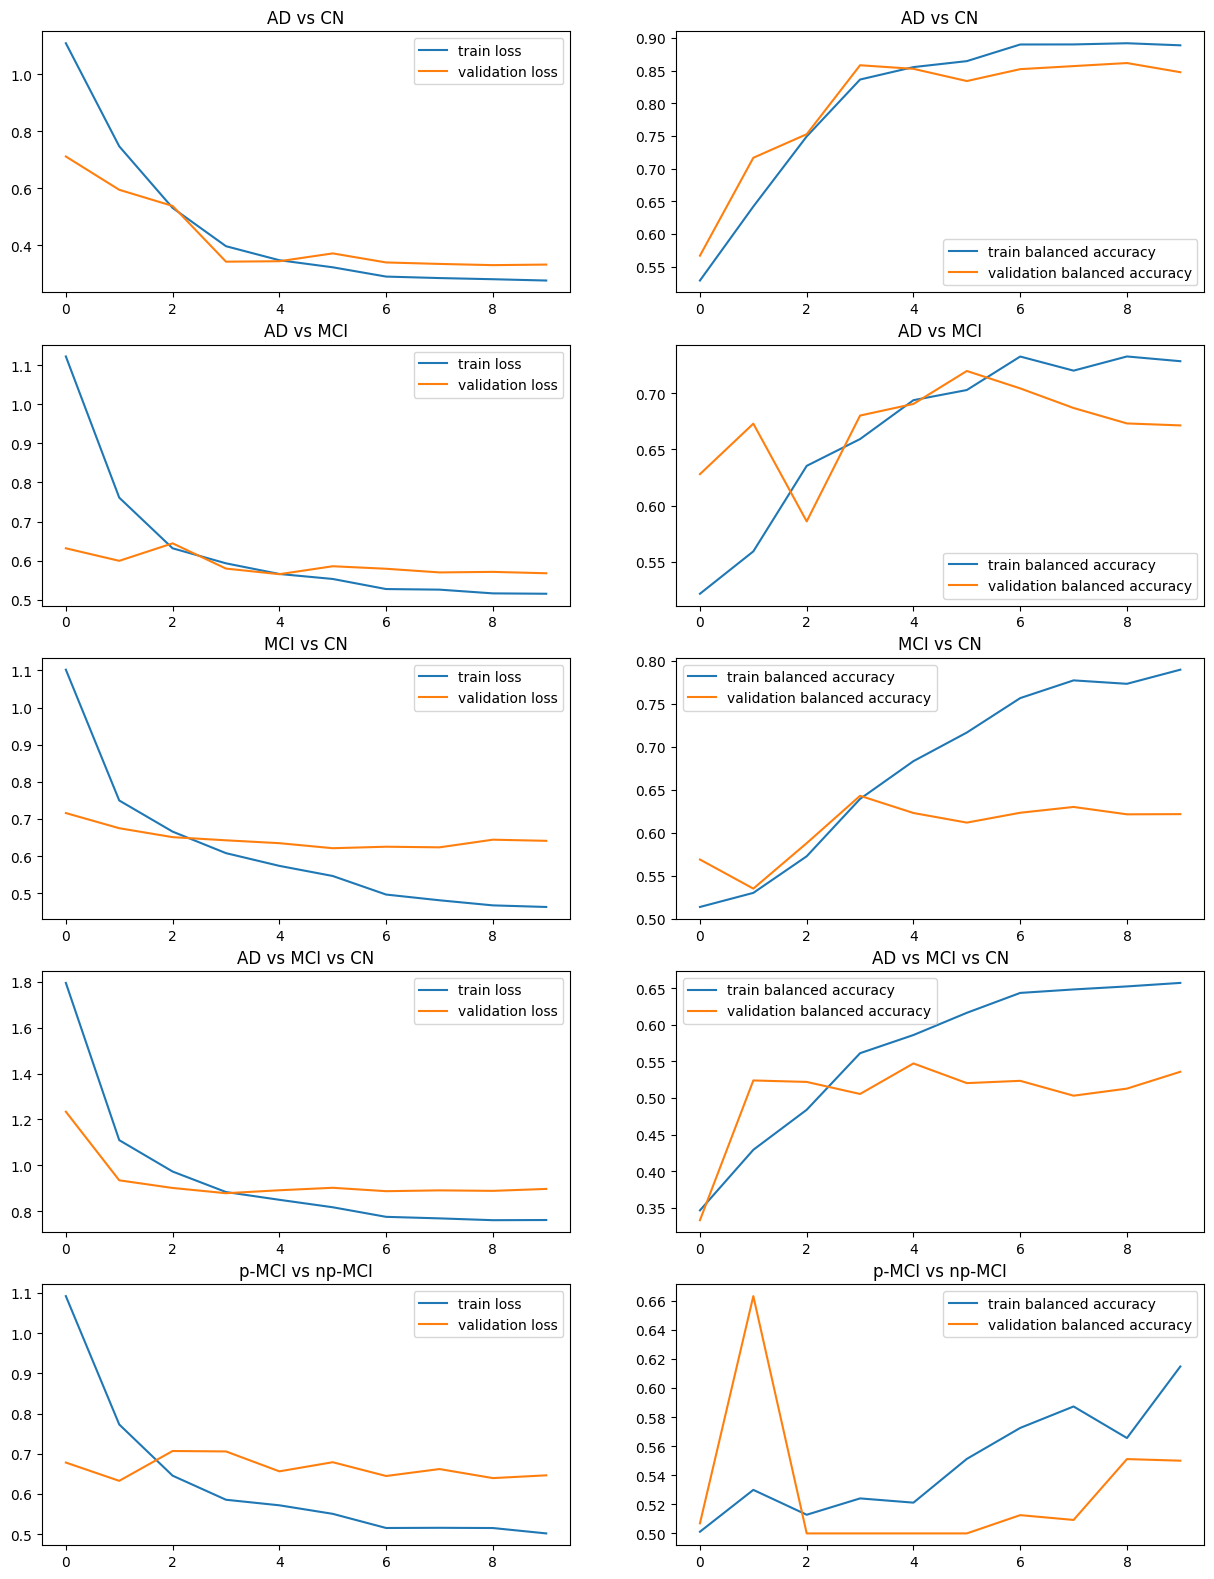

<Figure size 640x480 with 0 Axes>

In [15]:
plt.figure(figsize=(15, 40))
for i, problem in enumerate(problems):
    plt.subplot(10, 2, i*2+1)
    plt.plot(histories[problem]["train_loss"], label="train loss")
    plt.plot(histories[problem]["valid_loss"], label="validation loss")
    plt.title(problem)
    plt.legend()
    plt.subplot(10, 2, i*2+2)
    plt.plot(histories[problem]["train_balanced_accuracy"], label="train balanced accuracy")
    plt.plot(histories[problem]["valid_balanced_accuracy"], label="validation balanced accuracy")
    plt.title(problem)
    plt.legend()
plt.show()
plt.savefig(Path(MODEL_SAVE_DIRECTORY, "training_history.png"))

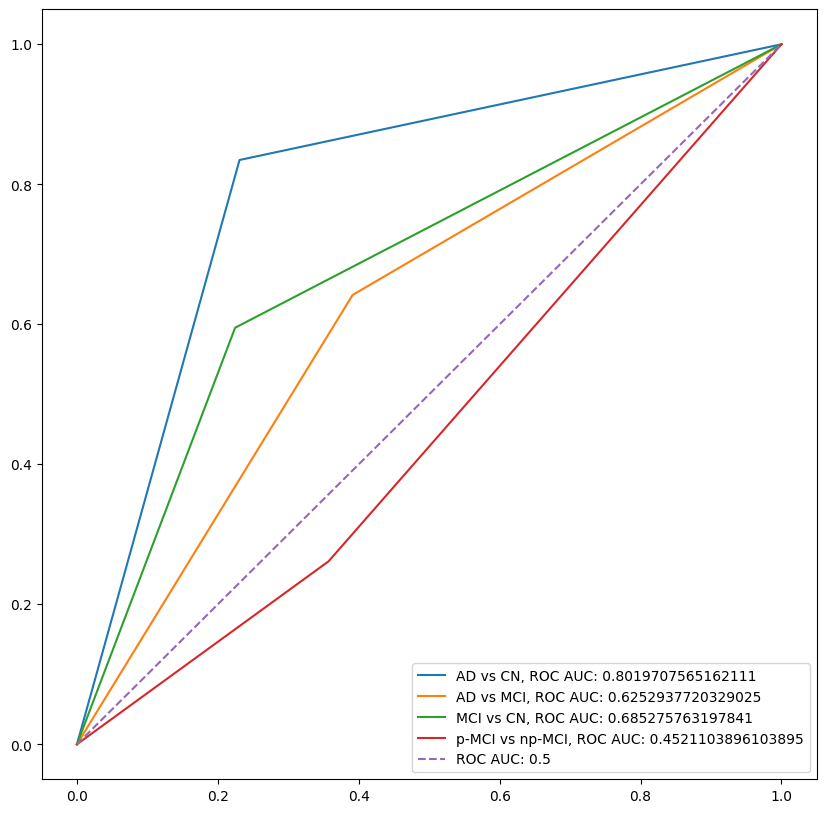

In [22]:
plt.figure(figsize=(10, 10))
for i, problem in enumerate(problems):
    if problem == "AD vs MCI vs CN":
        continue
    curve = results[problem]["test"]["roc_curve"]
    plt.plot(curve[0], curve[1], label=f"{problem}, ROC AUC: {results[problem]['test']['roc_auc']}")
plt.plot([0, 1], [0, 1], linestyle='--', label="ROC AUC: 0.5")
plt.legend()
plt.show()

In [23]:
results_dfs = {problem: pd.DataFrame(results[problem]).drop(["roc_curve", "confusion_matrix"], axis=0, errors="ignore") for problem in problems}

In [24]:
results_dfs["AD vs CN"]

,train,test,valid,biocard
accuracy,0.90534,0.806604,0.862745,0.097059
balanced_accuracy,0.904828,0.801971,0.861451,0.540419
roc_auc,0.904828,0.801971,0.861451,0.540419


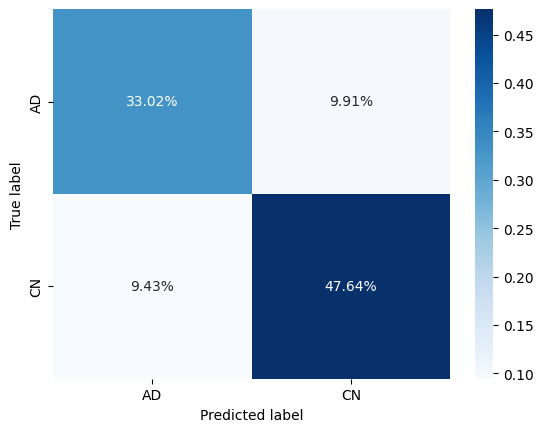

In [25]:
plot_confusion_matrix(results, "AD vs CN", "test")

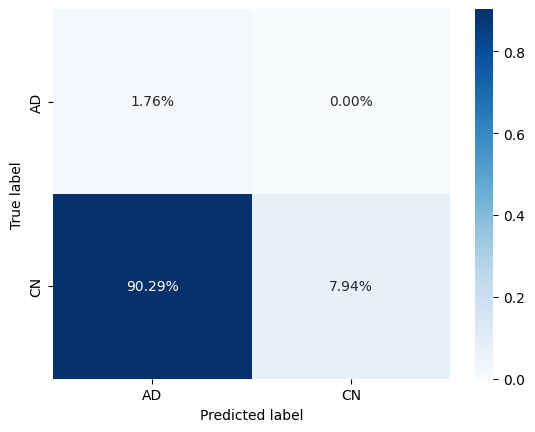

In [26]:
plot_confusion_matrix(results, "AD vs CN", "biocard")

In [27]:
results_dfs["AD vs MCI"]

,train,test,valid,biocard
accuracy,0.759481,0.629167,0.721311,0.092593
balanced_accuracy,0.750239,0.625294,0.719616,0.519608
roc_auc,0.750239,0.625294,0.719616,0.519608


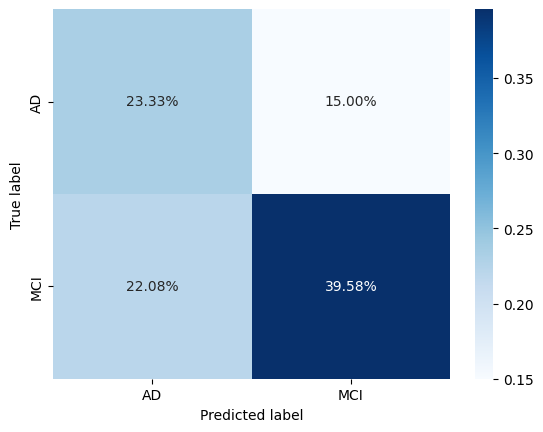

In [28]:
plot_confusion_matrix(results, "AD vs MCI", "test")

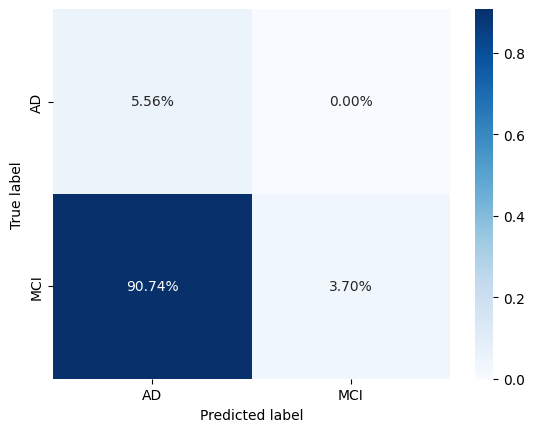

In [29]:
plot_confusion_matrix(results, "AD vs MCI", "biocard")

In [30]:
results_dfs["MCI vs CN"]

,train,test,valid,biocard
accuracy,0.717758,0.69403,0.646825,0.361364
balanced_accuracy,0.726843,0.685276,0.650242,0.557711
roc_auc,0.726843,0.685276,0.650242,0.557711


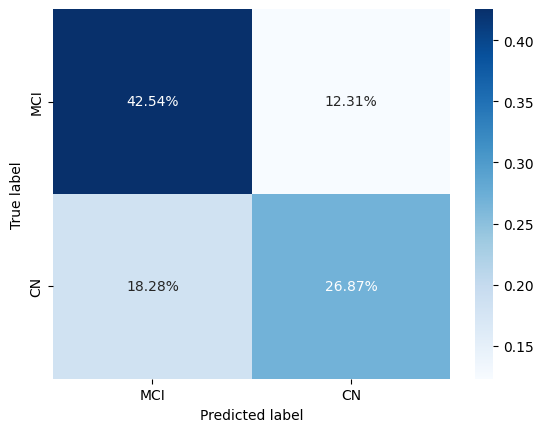

In [31]:
plot_confusion_matrix(results, "MCI vs CN", "test")

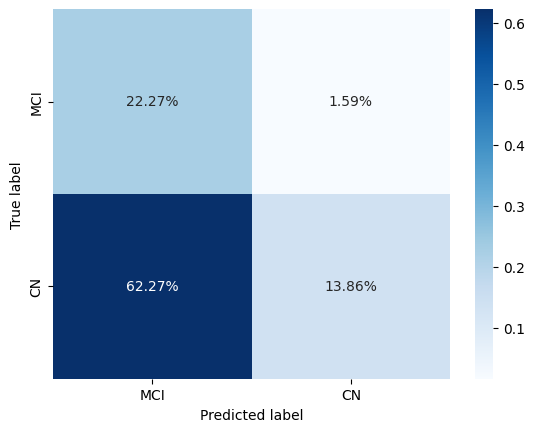

In [32]:
plot_confusion_matrix(results, "MCI vs CN", "biocard")

In [33]:
results_dfs["AD vs MCI vs CN"]

,train,test,valid,biocard
accuracy,0.632581,0.508333,0.525862,0.015766
balanced_accuracy,0.655065,0.531563,0.551992,0.33657


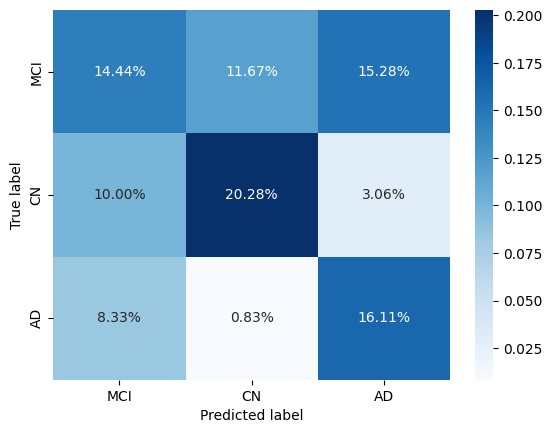

In [34]:
plot_confusion_matrix(results, "AD vs MCI vs CN", "test")

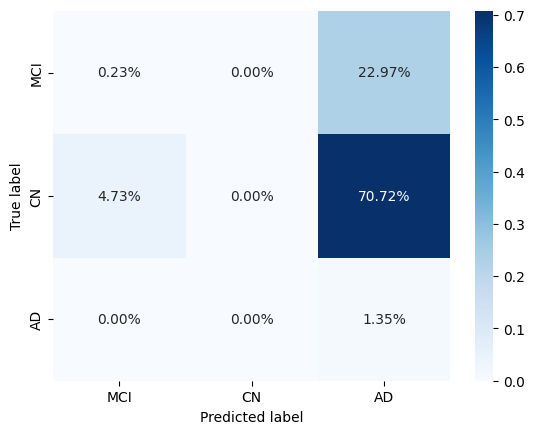

In [35]:
plot_confusion_matrix(results, "AD vs MCI vs CN", "biocard")

In [36]:
results_dfs["p-MCI vs np-MCI"]

,train,test,valid,biocard
accuracy,0.454467,0.409722,0.625,None
balanced_accuracy,0.515986,0.45211,0.659259,None
roc_auc,0.515986,0.45211,0.659259,None


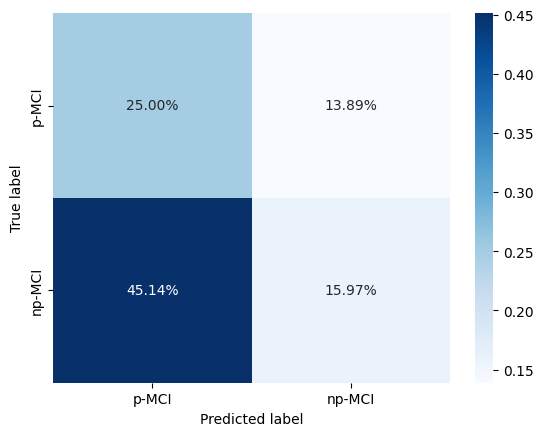

In [39]:
plot_confusion_matrix(results, "p-MCI vs np-MCI", "test")

### Augmentations

/tmp/ipykernel_954127/4208077403.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i+1)


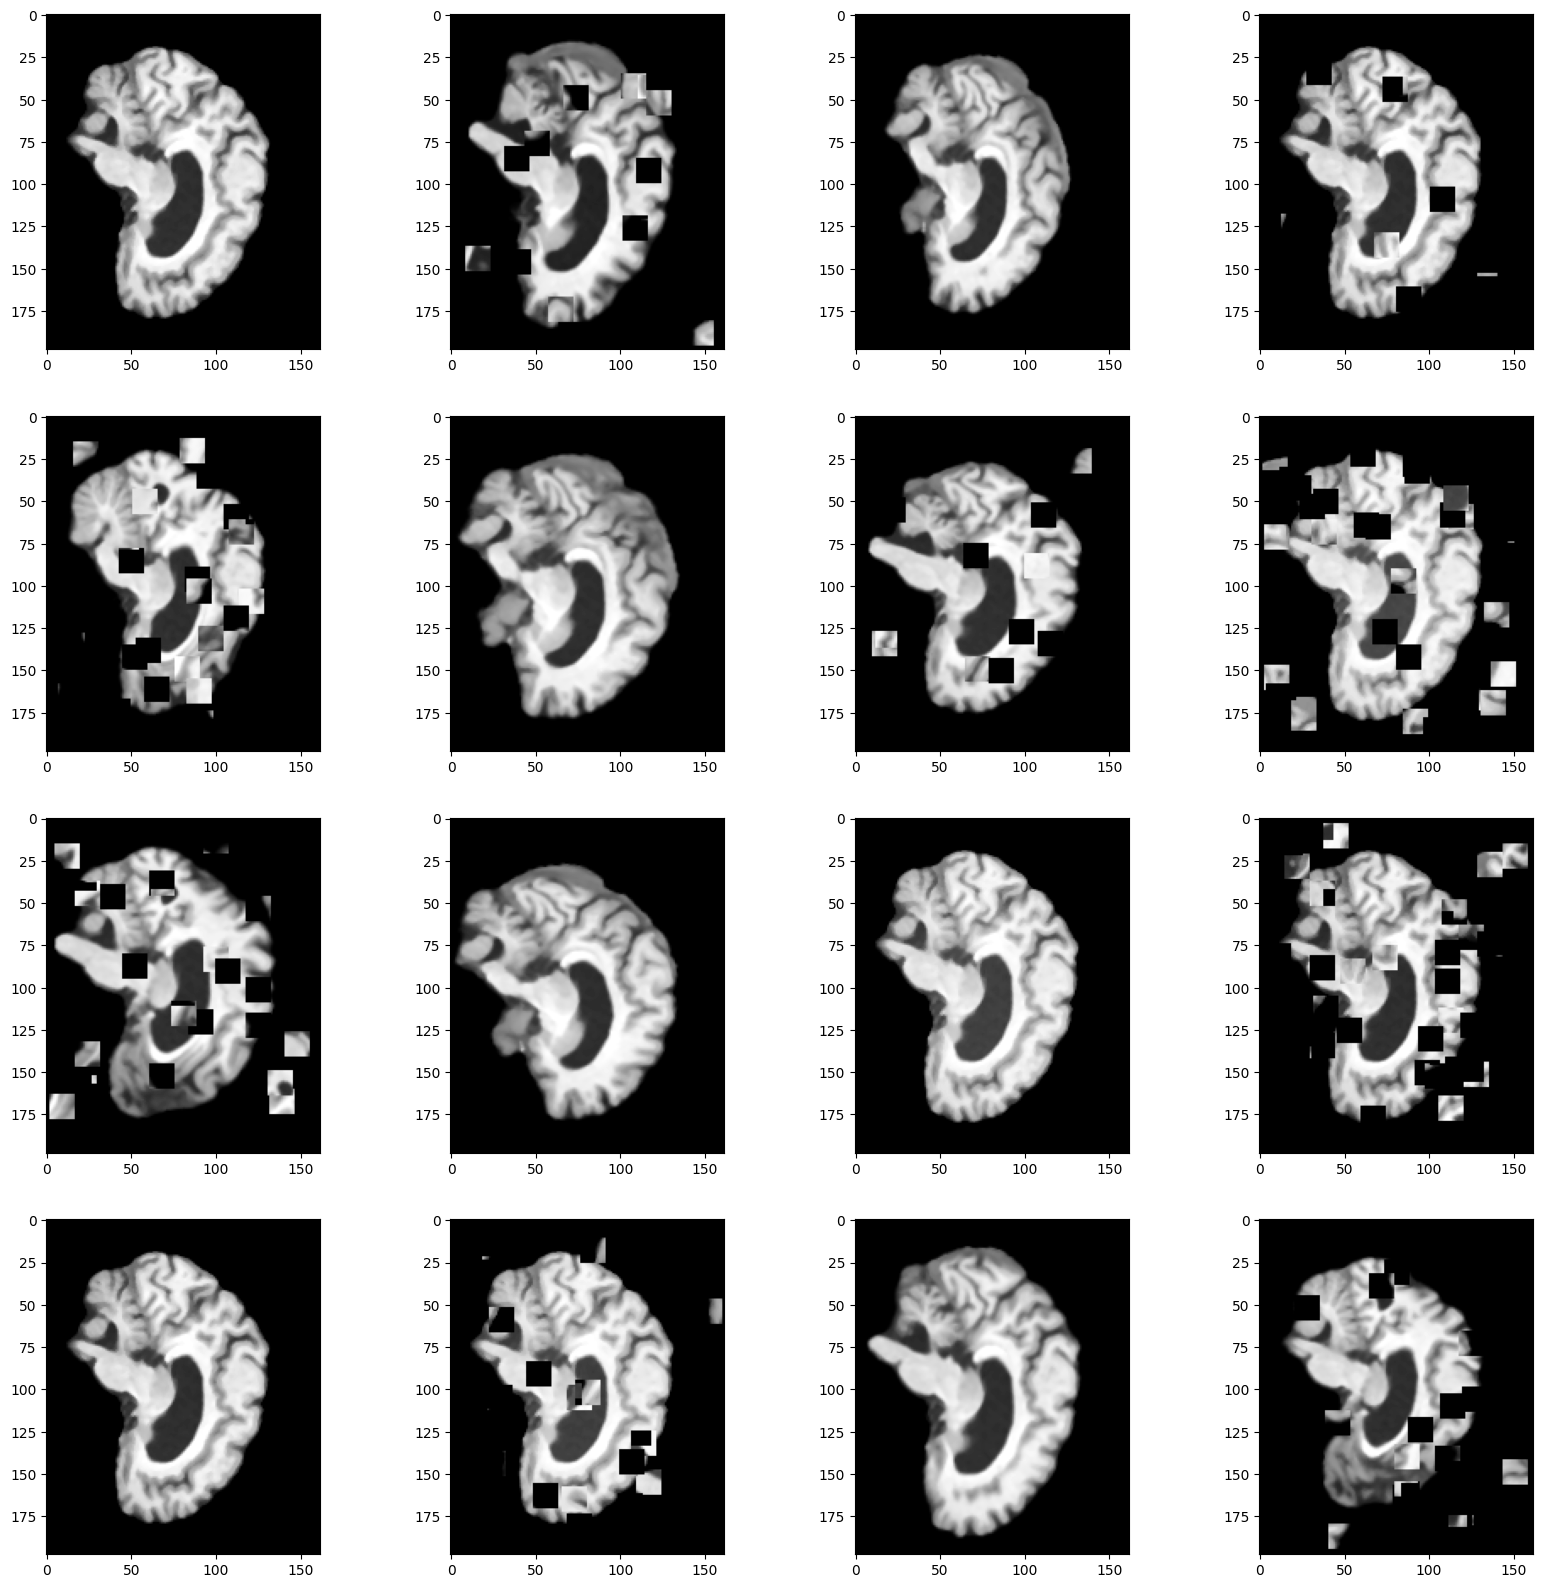

In [40]:
augment_dataloader = Mri3DDataLoader(filter_df_by_problem("AD vs CN", train_df), classification_values=["AD", "CN"], batch_size=batch_size, augment=True)

plt.figure(figsize=(20, 20))
plt.title("Augmented images")
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = augment_dataloader.get_single_item(5)[0].cpu().numpy()
    plt.imshow(image[0,0,70, :, :], cmap="gray")
plt.savefig(Path(MODEL_SAVE_DIRECTORY, "augmentation_sample.png"))
plt.show()

In [41]:
augment_histories = {}
augment_results = {problem: {} for problem in problems}
for problem, columns in problems.items():
    print(f"Training {problem}")
    _train_df = Mri3DDataLoader(filter_df_by_problem(problem, train_df), classification_values=columns,
                                batch_size=batch_size, crop=False, augment=True)
    _test_df = Mri3DDataLoader(filter_df_by_problem(problem, test_df), classification_values=columns,
                               batch_size=batch_size, crop=False)
    _valid_df = Mri3DDataLoader(filter_df_by_problem(problem, valid_df), classification_values=columns,
                                batch_size=batch_size, crop=False)
    if problem != "p-MCI vs np-MCI":
        _biocard_df = Mri3DDataLoader(filter_df_by_problem(problem, biocard_df), classification_values=columns, batch_size=batch_size)
    else:
        _biocard_df = None
    save_directory = Path(MODEL_SAVE_DIRECTORY, "augmentations", problem)
    model = MRINet(num_classes=2 if problem != "AD vs MCI vs CN" else 3)
    state_dict = torch.load(r"/home/dpolak/alzheimer_disease_classification_tools/imaging_models/models/pretrained/best_model.pth")
    state_dict.pop('classifier.2.weight')
    state_dict.pop('classifier.2.bias')
    model.load_state_dict(state_dict, strict=False)
    model.to("cuda")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    history = run_training_loop(model = model,
                                train_dataset=_train_df,
                                valid_dataset=_valid_df,
                                num_epochs = num_epochs,
                                optimizer = optimizer,
                                batch_size = batch_size,
                                save_directory = save_directory,
                                from_pretrained = True,
                                scheduler=torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1, last_epoch=-1))
    augment_histories[problem] = history
    model.load_state_dict(torch.load(Path(save_directory, "best_model.pth")))
    augment_results[problem] = {
        "train": evaluate_model(model, _train_df),
        "test": evaluate_model(model, _test_df),
        "valid": evaluate_model(model, _valid_df),
        "biocard": evaluate_model(model, _biocard_df) if _biocard_df is not None else None
    }
    print(results)

Training AD vs CN
Freezing all layers except the last fully connected layer.


Epoch: 0, LR: [0.001] Step loss: 1.224, Step acc: 1, Train Accuracy: 0.521, Balanced Accuracy: 0.521, Running Loss: 1.067: 100%|█| 41
Validation Loss - item: 0.574, Validation Accuracy: 0.627, Balanced accuracy: 0.62, Running Loss: 0.641: 100%|█| 51/51 [00:25<00:00, 



Best validation accuracy: 0.6202909721553136

Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 0.661, Step acc: 2, Train Accuracy: 0.614, Balanced Accuracy: 0.614, Running Loss: 0.745: 100%|█| 41
Validation Loss - item: 0.444, Validation Accuracy: 0.76, Balanced accuracy: 0.751, Running Loss: 0.51: 100%|█| 51/51 [00:22<00:00,  



Best validation accuracy: 0.7512766162443395

Saving best model for epoch: 2



Epoch: 2, LR: [0.001] Step loss: 0.54, Step acc: 3, Train Accuracy: 0.691, Balanced Accuracy: 0.691, Running Loss: 0.609: 100%|█| 412
Validation Loss - item: 1.07, Validation Accuracy: 0.49, Balanced accuracy: 0.513, Running Loss: 1.445: 100%|█| 51/51 [00:22<00:00,  
Epoch: 3, LR: [0.0001] Step loss: 0.465, Step acc: 3, Train Accuracy: 0.764, Balanced Accuracy: 0.764, Running Loss: 0.512: 100%|█| 4
Validation Loss - item: 0.498, Validation Accuracy: 0.848, Balanced accuracy: 0.845, Running Loss: 0.395: 100%|█| 51/51 [00:22<00:00,



Best validation accuracy: 0.8450236053569709

Saving best model for epoch: 4



Epoch: 4, LR: [0.0001] Step loss: 1.324, Step acc: 2, Train Accuracy: 0.775, Balanced Accuracy: 0.775, Running Loss: 0.484: 100%|█| 4
Validation Loss - item: 0.899, Validation Accuracy: 0.863, Balanced accuracy: 0.86, Running Loss: 0.361: 100%|█| 51/51 [00:25<00:00, 



Best validation accuracy: 0.860005780903748

Saving best model for epoch: 5



Epoch: 5, LR: [0.0001] Step loss: 0.611, Step acc: 3, Train Accuracy: 0.8, Balanced Accuracy: 0.8, Running Loss: 0.445: 100%|█| 412/4
Validation Loss - item: 0.66, Validation Accuracy: 0.828, Balanced accuracy: 0.829, Running Loss: 0.365: 100%|█| 51/51 [00:25<00:00, 
Epoch: 6, LR: [1e-05] Step loss: 0.116, Step acc: 4, Train Accuracy: 0.809, Balanced Accuracy: 0.809, Running Loss: 0.433: 100%|█| 41
Validation Loss - item: 0.204, Validation Accuracy: 0.853, Balanced accuracy: 0.85, Running Loss: 0.351: 100%|█| 51/51 [00:25<00:00, 
Epoch: 7, LR: [1e-05] Step loss: 0.475, Step acc: 3, Train Accuracy: 0.809, Balanced Accuracy: 0.808, Running Loss: 0.412: 100%|█| 41
Validation Loss - item: 0.113, Validation Accuracy: 0.848, Balanced accuracy: 0.845, Running Loss: 0.349: 100%|█| 51/51 [00:25<00:00,
Epoch: 8, LR: [1e-05] Step loss: 1.075, Step acc: 2, Train Accuracy: 0.82, Balanced Accuracy: 0.82, Running Loss: 0.41: 100%|█| 412/4
Validation Loss - item: 0.316, Validation Accuracy: 0.853, Bal

{'AD vs CN': {'train': {'accuracy': 0.9053398058252428, 'balanced_accuracy': 0.9048277649879883, 'roc_auc': 0.9048277649879883, 'roc_curve': (array([0.        , 0.15544676, 1.        ]), array([0.        , 0.96510229, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[690, 127],
       [ 29, 802]])}, 'test': {'accuracy': 0.8066037735849056, 'balanced_accuracy': 0.8019707565162111, 'roc_auc': 0.8019707565162111, 'roc_curve': (array([0.        , 0.23076923, 1.        ]), array([0.        , 0.83471074, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 70,  21],
       [ 20, 101]])}, 'valid': {'accuracy': 0.8627450980392157, 'balanced_accuracy': 0.8614510068407362, 'roc_auc': 0.8614510068407362, 'roc_curve': (array([0.        , 0.16494845, 1.        ]), array([0.        , 0.88785047, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[81, 16],
       [12, 95]])}, 'biocard': {'accuracy': 0.09705882352941177, 'balanced_accuracy': 0.54041916167

Epoch: 0, LR: [0.001] Step loss: 0.388, Step acc: 3, Train Accuracy: 0.527, Balanced Accuracy: 0.505, Running Loss: 1.058: 100%|█| 50
Validation Loss - item: 0.652, Validation Accuracy: 0.602, Balanced accuracy: 0.5, Running Loss: 0.808: 100%|█| 61/61 [00:27<00:00,  



Best validation accuracy: 0.5

Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 0.843, Step acc: 3, Train Accuracy: 0.562, Balanced Accuracy: 0.526, Running Loss: 0.757: 100%|█| 50
Validation Loss - item: 0.608, Validation Accuracy: 0.713, Balanced accuracy: 0.66, Running Loss: 0.6: 100%|█| 61/61 [00:26<00:00,  2



Best validation accuracy: 0.6602146013044393

Saving best model for epoch: 2



Epoch: 2, LR: [0.001] Step loss: 0.384, Step acc: 4, Train Accuracy: 0.592, Balanced Accuracy: 0.552, Running Loss: 0.671: 100%|█| 50
Validation Loss - item: 1.243, Validation Accuracy: 0.619, Balanced accuracy: 0.521, Running Loss: 0.649: 100%|█| 61/61 [00:26<00:00,
Epoch: 3, LR: [0.0001] Step loss: 0.629, Step acc: 3, Train Accuracy: 0.627, Balanced Accuracy: 0.587, Running Loss: 0.634: 100%|█| 5
Validation Loss - item: 0.768, Validation Accuracy: 0.721, Balanced accuracy: 0.674, Running Loss: 0.586: 100%|█| 61/61 [00:26<00:00,



Best validation accuracy: 0.6740304369170349

Saving best model for epoch: 4



Epoch: 4, LR: [0.0001] Step loss: 0.675, Step acc: 2, Train Accuracy: 0.659, Balanced Accuracy: 0.624, Running Loss: 0.625: 100%|█| 5
Validation Loss - item: 0.581, Validation Accuracy: 0.717, Balanced accuracy: 0.664, Running Loss: 0.572: 100%|█| 61/61 [00:26<00:00,
Epoch: 5, LR: [0.0001] Step loss: 1.004, Step acc: 1, Train Accuracy: 0.682, Balanced Accuracy: 0.655, Running Loss: 0.607: 100%|█| 5
Validation Loss - item: 0.736, Validation Accuracy: 0.709, Balanced accuracy: 0.667, Running Loss: 0.558: 100%|█| 61/61 [00:30<00:00,
Epoch: 6, LR: [1e-05] Step loss: 0.568, Step acc: 3, Train Accuracy: 0.693, Balanced Accuracy: 0.668, Running Loss: 0.588: 100%|█| 50
Validation Loss - item: 0.578, Validation Accuracy: 0.713, Balanced accuracy: 0.68, Running Loss: 0.556: 100%|█| 61/61 [00:31<00:00, 



Best validation accuracy: 0.6795006662458798

Saving best model for epoch: 7



Epoch: 7, LR: [1e-05] Step loss: 0.314, Step acc: 4, Train Accuracy: 0.692, Balanced Accuracy: 0.669, Running Loss: 0.593: 100%|█| 50
Validation Loss - item: 0.254, Validation Accuracy: 0.705, Balanced accuracy: 0.669, Running Loss: 0.554: 100%|█| 61/61 [00:26<00:00,
Epoch: 8, LR: [1e-05] Step loss: 0.436, Step acc: 3, Train Accuracy: 0.688, Balanced Accuracy: 0.664, Running Loss: 0.599: 100%|█| 50
Validation Loss - item: 0.329, Validation Accuracy: 0.717, Balanced accuracy: 0.685, Running Loss: 0.547: 100%|█| 61/61 [00:26<00:00,



Best validation accuracy: 0.6846553054211375

Saving best model for epoch: 9



Epoch: 9, LR: [1.0000000000000002e-06] Step loss: 0.438, Step acc: 3, Train Accuracy: 0.673, Balanced Accuracy: 0.648, Running Loss: 
  0%|                                                                                                         | 0/61 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation Loss - item: 0.63, Validation Accuracy: 0.709, Balanced accuracy: 0.674, Running Loss: 0.55: 100%|█| 61/61 [00:30<00:00,  
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:17<00:00,  1.52it/s]


{'AD vs CN': {'train': {'accuracy': 0.9053398058252428, 'balanced_accuracy': 0.9048277649879883, 'roc_auc': 0.9048277649879883, 'roc_curve': (array([0.        , 0.15544676, 1.        ]), array([0.        , 0.96510229, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[690, 127],
       [ 29, 802]])}, 'test': {'accuracy': 0.8066037735849056, 'balanced_accuracy': 0.8019707565162111, 'roc_auc': 0.8019707565162111, 'roc_curve': (array([0.        , 0.23076923, 1.        ]), array([0.        , 0.83471074, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 70,  21],
       [ 20, 101]])}, 'valid': {'accuracy': 0.8627450980392157, 'balanced_accuracy': 0.8614510068407362, 'roc_auc': 0.8614510068407362, 'roc_curve': (array([0.        , 0.16494845, 1.        ]), array([0.        , 0.88785047, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[81, 16],
       [12, 95]])}, 'biocard': {'accuracy': 0.09705882352941177, 'balanced_accuracy': 0.54041916167

Epoch: 0, LR: [0.001] Step loss: 0.679, Step acc: 2, Train Accuracy: 0.519, Balanced Accuracy: 0.498, Running Loss: 1.096: 100%|█| 50
Validation Loss - item: 0.706, Validation Accuracy: 0.552, Balanced accuracy: 0.544, Running Loss: 0.686: 100%|█| 63/63 [00:28<00:00,



Best validation accuracy: 0.5442152755398002

Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 0.756, Step acc: 2, Train Accuracy: 0.544, Balanced Accuracy: 0.507, Running Loss: 0.762: 100%|█| 50
Validation Loss - item: 0.894, Validation Accuracy: 0.421, Balanced accuracy: 0.5, Running Loss: 1.03: 100%|█| 63/63 [00:28<00:00,  2
Epoch: 2, LR: [0.001] Step loss: 0.763, Step acc: 2, Train Accuracy: 0.561, Balanced Accuracy: 0.512, Running Loss: 0.689: 100%|█| 50
Validation Loss - item: 0.501, Validation Accuracy: 0.591, Balanced accuracy: 0.514, Running Loss: 0.662: 100%|█| 63/63 [00:27<00:00,
  0%|                                                                                                        | 0/504 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 3, LR: [0.0001] Step loss: 0.613, Step acc: 3, Train Accuracy: 0.75, Balanced Accuracy: 0.75, Running Loss: 0.61


Best validation accuracy: 0.5491782146310022

Saving best model for epoch: 4



Epoch: 4, LR: [0.0001] Step loss: 0.856, Step acc: 2, Train Accuracy: 0.589, Balanced Accuracy: 0.55, Running Loss: 0.648: 100%|█| 50
Validation Loss - item: 0.532, Validation Accuracy: 0.619, Balanced accuracy: 0.626, Running Loss: 0.651: 100%|█| 63/63 [00:27<00:00,



Best validation accuracy: 0.6260015507883174

Saving best model for epoch: 5



Epoch: 5, LR: [0.0001] Step loss: 0.7, Step acc: 2, Train Accuracy: 0.619, Balanced Accuracy: 0.583, Running Loss: 0.641: 100%|█| 504
Validation Loss - item: 0.628, Validation Accuracy: 0.615, Balanced accuracy: 0.628, Running Loss: 0.643: 100%|█| 63/63 [00:27<00:00,



Best validation accuracy: 0.6275539800193362

Saving best model for epoch: 6



  0%|                                                                                                        | 0/504 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 6, LR: [1e-05] Step loss: 0.632, Step acc: 2, Train Accuracy: 0.632, Balanced Accuracy: 0.612, Running Loss: 0.631: 100%|█| 50
Validation Loss - item: 0.651, Validation Accuracy: 0.603, Balanced accuracy: 0.575, Running Loss: 0.635: 100%|█| 63/63 [00:27<00:00,
Epoch: 7, LR: [1e-05] Step loss: 0.775, Step acc: 0, Train Accuracy: 0.62, Balanced Accuracy: 0.59, Running Loss: 0.632: 100%|█| 504/
Validation Loss - item: 0.798, Validation Accuracy: 0.587, Balanced accuracy: 0.573, Running Loss: 0.633: 100%|█| 63/63 [00:27<00:00,
  0%|                                                                                                        | 0/504 [0

{'AD vs CN': {'train': {'accuracy': 0.9053398058252428, 'balanced_accuracy': 0.9048277649879883, 'roc_auc': 0.9048277649879883, 'roc_curve': (array([0.        , 0.15544676, 1.        ]), array([0.        , 0.96510229, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[690, 127],
       [ 29, 802]])}, 'test': {'accuracy': 0.8066037735849056, 'balanced_accuracy': 0.8019707565162111, 'roc_auc': 0.8019707565162111, 'roc_curve': (array([0.        , 0.23076923, 1.        ]), array([0.        , 0.83471074, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 70,  21],
       [ 20, 101]])}, 'valid': {'accuracy': 0.8627450980392157, 'balanced_accuracy': 0.8614510068407362, 'roc_auc': 0.8614510068407362, 'roc_curve': (array([0.        , 0.16494845, 1.        ]), array([0.        , 0.88785047, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[81, 16],
       [12, 95]])}, 'biocard': {'accuracy': 0.09705882352941177, 'balanced_accuracy': 0.54041916167

  0%|                                                                                                        | 0/709 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 0, LR: [0.001] Step loss: 5.261, Step acc: 0, Train Accuracy: 0.0, Balanced Accuracy: 0.0, Running Loss: 5.261:   0%| | 1/709 /home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 0, LR: [0.001] Step loss: 1.661, Step acc: 0, Train Accuracy: 0.371, Balanced Accuracy: 0.357, Running Loss: 1.662: 100%|█| 70
Validation Loss - item: 0.955, Validation Accuracy: 0.414, Balanced accuracy: 0.333, Running Loss: 1.179: 100%|█| 87/87 [00:38<00:00,



Best validation accuracy: 0.3333333333333333

Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 0.8, Step acc: 2, Train Accuracy: 0.388, Balanced Accuracy: 0.368, Running Loss: 1.157: 100%|█| 709/
Validation Loss - item: 0.929, Validation Accuracy: 0.5, Balanced accuracy: 0.667, Running Loss: 0.929:   1%| | 1/87 [00:00<00:39,  2/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Validation Loss - item: 1.106, Validation Accuracy: 0.457, Balanced accuracy: 0.455, Running Loss: 0.972: 100%|█| 87/87 [00:39<00:00,



Best validation accuracy: 0.4553901717550823

Saving best model for epoch: 2



  0%|                                                                                                        | 0/709 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 2, LR: [0.001] Step loss: 1.199, Step acc: 0, Train Accuracy: 0.455, Balanced Accuracy: 0.439, Running Loss: 1.032: 100%|█| 70
Validation Loss - item: 1.097, Validation Accuracy: 0.374, Balanced accuracy: 0.418, Running Loss: 1.106: 100%|█| 87/87 [00:38<00:00,
Epoch: 3, LR: [0.0001] Step loss: 0.68, Step acc: 2, Train Accuracy: 0.487, Balanced Accuracy: 0.488, Running Loss: 0.959: 100%|█| 70
Validation Loss - item: 0.805, Validation Accuracy: 0.509, Balanced accuracy: 0.518, Running Loss: 0.906: 100%|█| 87/87 [00:37<00:00,



Best validation accuracy: 0.5184017600225369

Saving best model for epoch: 4



  0%|                                                                                                        | 0/709 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 4, LR: [0.0001] Step loss: 1.553, Step acc: 0, Train Accuracy: 0.495, Balanced Accuracy: 0.492, Running Loss: 0.959: 100%|█| 7
Validation Loss - item: 0.804, Validation Accuracy: 0.517, Balanced accuracy: 0.528, Running Loss: 0.887: 100%|█| 87/87 [00:38<00:00,



Best validation accuracy: 0.5276196304440902

Saving best model for epoch: 5



  0%|                                                                                                        | 0/709 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 5, LR: [0.0001] Step loss: 0.677, Step acc: 3, Train Accuracy: 0.52, Balanced Accuracy: 0.523, Running Loss: 0.93: 100%|█| 709
Validation Loss - item: 1.063, Validation Accuracy: 0.491, Balanced accuracy: 0.47, Running Loss: 0.914: 100%|█| 87/87 [00:38<00:00, 
  0%|                                                                                                        | 0/709 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 6, LR: [1e-05] Step loss: 0.847, St

{'AD vs CN': {'train': {'accuracy': 0.9053398058252428, 'balanced_accuracy': 0.9048277649879883, 'roc_auc': 0.9048277649879883, 'roc_curve': (array([0.        , 0.15544676, 1.        ]), array([0.        , 0.96510229, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[690, 127],
       [ 29, 802]])}, 'test': {'accuracy': 0.8066037735849056, 'balanced_accuracy': 0.8019707565162111, 'roc_auc': 0.8019707565162111, 'roc_curve': (array([0.        , 0.23076923, 1.        ]), array([0.        , 0.83471074, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 70,  21],
       [ 20, 101]])}, 'valid': {'accuracy': 0.8627450980392157, 'balanced_accuracy': 0.8614510068407362, 'roc_auc': 0.8614510068407362, 'roc_curve': (array([0.        , 0.16494845, 1.        ]), array([0.        , 0.88785047, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[81, 16],
       [12, 95]])}, 'biocard': {'accuracy': 0.09705882352941177, 'balanced_accuracy': 0.54041916167

Epoch: 0, LR: [0.001] Step loss: 0.521, Step acc: 3, Train Accuracy: 0.612, Balanced Accuracy: 0.497, Running Loss: 0.961: 100%|█| 29
Validation Loss - item: 0.17, Validation Accuracy: 0.618, Balanced accuracy: 0.5, Running Loss: 0.847: 100%|█| 36/36 [00:16<00:00,  2



Best validation accuracy: 0.5

Saving best model for epoch: 1

Unfreezing all layers.


Epoch: 1, LR: [0.001] Step loss: 0.381, Step acc: 4, Train Accuracy: 0.643, Balanced Accuracy: 0.51, Running Loss: 0.77: 100%|█| 291/
Validation Loss - item: 0.727, Validation Accuracy: 0.618, Balanced accuracy: 0.5, Running Loss: 0.641: 100%|█| 36/36 [00:16<00:00,  
  0%|                                                                                                        | 0/291 [00:00<?, ?it/s]/home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 2, LR: [0.001] Step loss: 0.651, Step acc: 2, Train Accuracy: 0.5, Balanced Accuracy: 0.5, Running Loss: 0.651:   0%| | 1/291 /home/dpolak/miniconda3/envs/adct/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
Epoch: 2, LR: [0.001] Step loss: 0.44, Ste

{'AD vs CN': {'train': {'accuracy': 0.9053398058252428, 'balanced_accuracy': 0.9048277649879883, 'roc_auc': 0.9048277649879883, 'roc_curve': (array([0.        , 0.15544676, 1.        ]), array([0.        , 0.96510229, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[690, 127],
       [ 29, 802]])}, 'test': {'accuracy': 0.8066037735849056, 'balanced_accuracy': 0.8019707565162111, 'roc_auc': 0.8019707565162111, 'roc_curve': (array([0.        , 0.23076923, 1.        ]), array([0.        , 0.83471074, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[ 70,  21],
       [ 20, 101]])}, 'valid': {'accuracy': 0.8627450980392157, 'balanced_accuracy': 0.8614510068407362, 'roc_auc': 0.8614510068407362, 'roc_curve': (array([0.        , 0.16494845, 1.        ]), array([0.        , 0.88785047, 1.        ]), array([inf,  1.,  0.])), 'confusion_matrix': array([[81, 16],
       [12, 95]])}, 'biocard': {'accuracy': 0.09705882352941177, 'balanced_accuracy': 0.54041916167

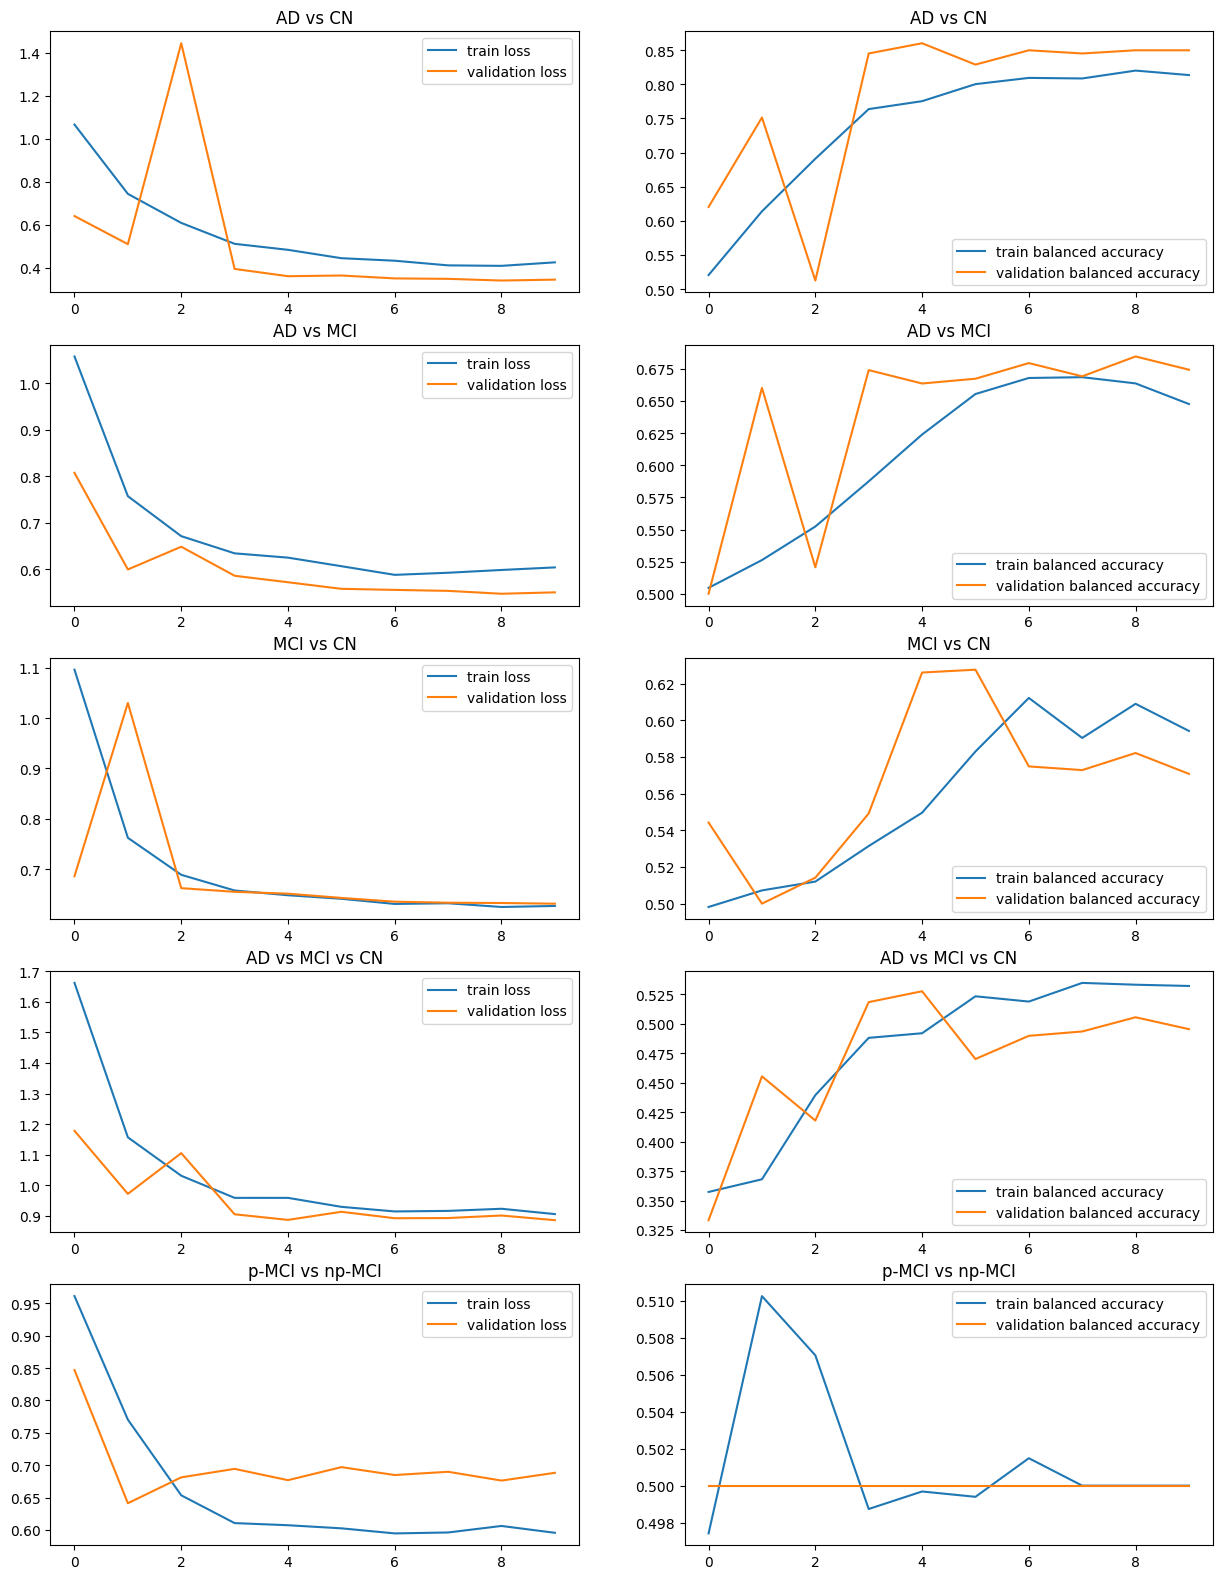

<Figure size 640x480 with 0 Axes>

In [42]:
plt.figure(figsize=(15, 40))
for i, problem in enumerate(problems):
    plt.subplot(10, 2, i*2+1)
    plt.plot(augment_histories[problem]["train_loss"], label="train loss")
    plt.plot(augment_histories[problem]["valid_loss"], label="validation loss")
    plt.title(problem)
    plt.legend()
    plt.subplot(10, 2, i*2+2)
    plt.plot(augment_histories[problem]["train_balanced_accuracy"], label="train balanced accuracy")
    plt.plot(augment_histories[problem]["valid_balanced_accuracy"], label="validation balanced accuracy")
    plt.title(problem)
    plt.legend()
plt.show()
plt.savefig(Path(MODEL_SAVE_DIRECTORY, "training_history_augmentation.png"))

In [43]:
results_dfs = {problem: pd.DataFrame(augment_results[problem]).drop(["roc_curve", "confusion_matrix"], axis=0, errors="ignore") for problem in problems}

In [44]:
results_dfs["AD vs CN"]

,train,test,valid,biocard
accuracy,0.817961,0.79717,0.862745,0.464706
balanced_accuracy,0.817618,0.790982,0.860006,0.645709
roc_auc,0.817618,0.790982,0.860006,0.645709


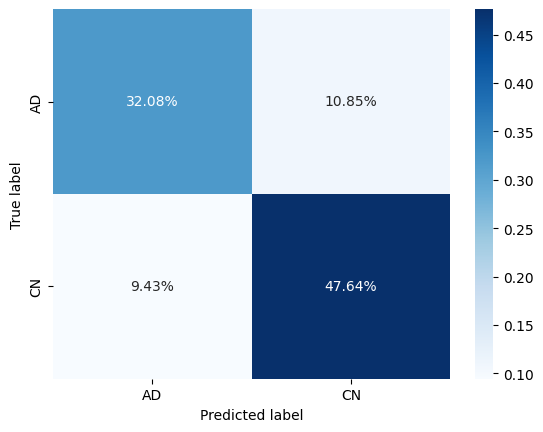

In [45]:
plot_confusion_matrix(augment_results, "AD vs CN", "test")

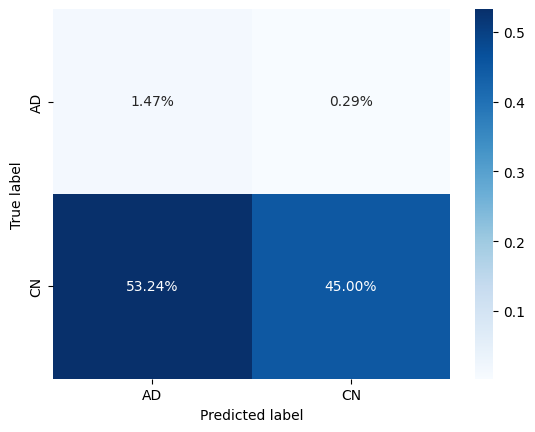

In [46]:
plot_confusion_matrix(augment_results, "AD vs CN", "biocard")

In [47]:
results_dfs["AD vs MCI"]

,train,test,valid,biocard
accuracy,0.686627,0.591667,0.717213,0.231481
balanced_accuracy,0.6645,0.572756,0.684655,0.514706
roc_auc,0.6645,0.572756,0.684655,0.514706


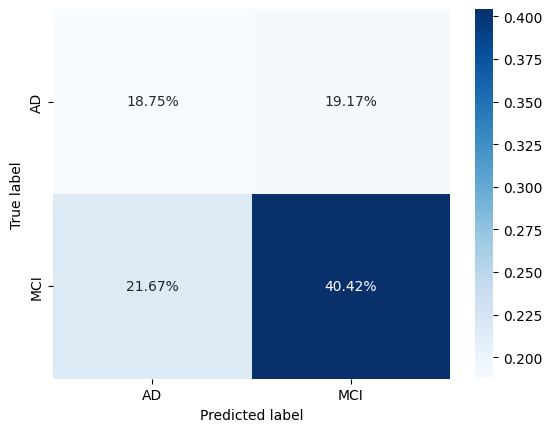

In [48]:
plot_confusion_matrix(augment_results, "AD vs MCI", "test")

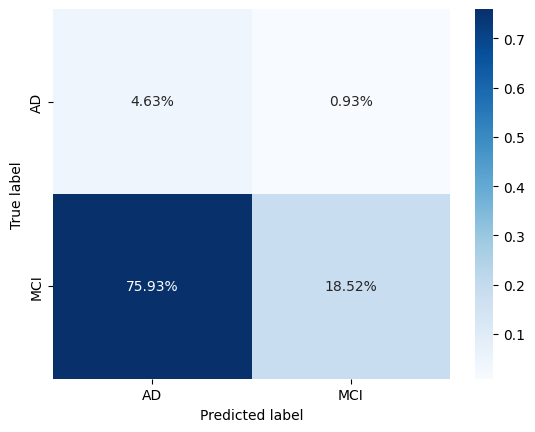

In [49]:
plot_confusion_matrix(augment_results, "AD vs MCI", "biocard")

In [50]:
results_dfs["MCI vs CN"]

,train,test,valid,biocard
accuracy,0.617063,0.645522,0.615079,0.25
balanced_accuracy,0.612969,0.63964,0.627891,0.504193
roc_auc,0.612969,0.63964,0.627891,0.504193


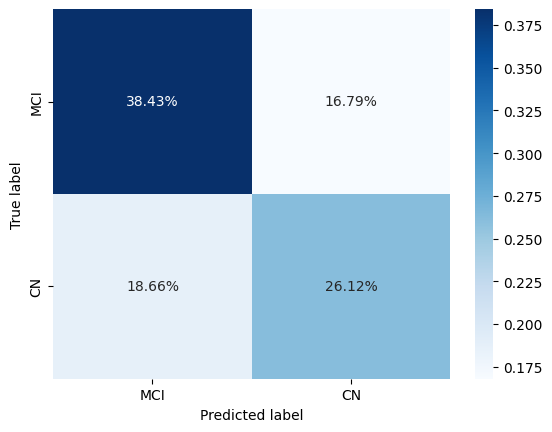

In [51]:
plot_confusion_matrix(augment_results, "MCI vs CN", "test")

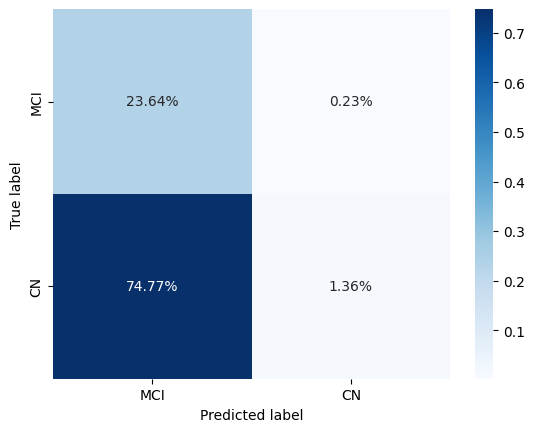

In [52]:
plot_confusion_matrix(augment_results, "MCI vs CN", "biocard")

In [53]:
results_dfs["AD vs MCI vs CN"]

,train,test,valid,biocard
accuracy,0.526093,0.477778,0.520115,0.123874
balanced_accuracy,0.540882,0.492602,0.530811,0.400513


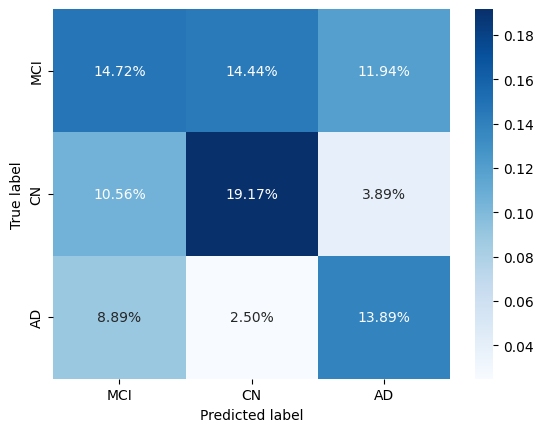

In [54]:
plot_confusion_matrix(augment_results, "AD vs MCI vs CN", "test")

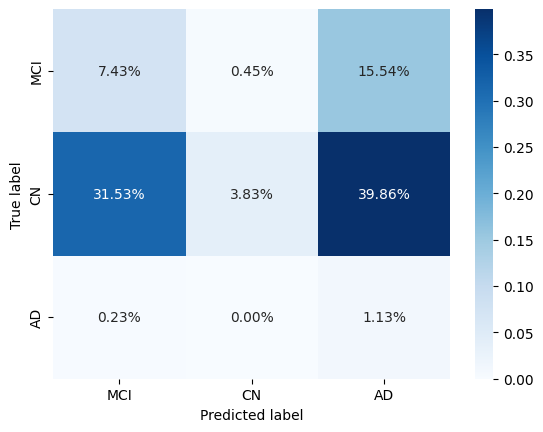

In [55]:
plot_confusion_matrix(augment_results, "AD vs MCI vs CN", "biocard")

In [56]:
results_dfs["p-MCI vs np-MCI"]

,train,test,valid,biocard
accuracy,0.710481,0.611111,0.611111,None
balanced_accuracy,0.5,0.5,0.5,None
roc_auc,0.5,0.5,0.5,None


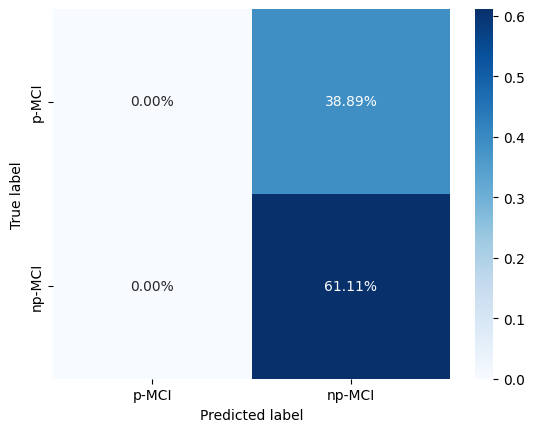

In [57]:
plot_confusion_matrix(augment_results, "p-MCI vs np-MCI", "test")